## Week 3 workshop

In this week, we'll build and run a basic multi-layer perceptron, and use it to recognize the digits in the MNIST dataset.

First we import the required dependencies:

In [1]:
import numpy as np
import pandas as pd
import plotnine as gg; gg.theme_set(gg.theme_bw())
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from prettytable import PrettyTable

## Defining the model

Next we define the model. We are using a fully connected feed-forward network with two hidden layers.

In [2]:
hidden_dim_1 = 16
hidden_dim_2 = 16

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, hidden_dim_1)
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.fc3 = nn.Linear(hidden_dim_2, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

## Training and testing functions

The following functions are needed to train and test the model.

This function trains one epoch of the model:

In [3]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    met = pd.DataFrame({"epoch" : [epoch for _ in range(len(train_loader))],
                        "batch" : range(len(train_loader)),
                        "train_loss" : np.zeros(len(train_loader)),
                        "train_accuracy" : np.zeros(len(train_loader))})
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        met.loc[(epoch, batch_idx), "train_loss"] = loss.item()
        resub = output.argmax(dim=1, keepdim=True)
        met.loc[(epoch, batch_idx), "train_accuracy"] =\
            resub.eq(target.view_as(resub)).sum().item() / len(target)
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return met.reset_index().loc[:, ["epoch", "batch", "train_loss", "train_accuracy"]]

And this function tests the model on the test data:

In [4]:
def test(model, device, test_loader):
    model.eval()
    met = pd.DataFrame({"epoch" : [epoch],
                        "test_loss" : [0.0],
                        "test_accuracy" : [0.0]})
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    met.loc[0, "test_loss"] = test_loss
    met.loc[0, "test_accuracy"] = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return met.loc[:, ["epoch", "test_loss", "test_accuracy"]]

Finally, the following is a useful function to summarize model parameters:

In [5]:
# from: https://stackoverflow.com/a/62508086/4975218
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}\n")
    return total_params

## Training the model

Before we run the actual training, we define all the required parameter settings:

In [6]:
# parameters controlling the training run
class args: pass
args.batch_size = 64
args.test_batch_size = 1000
args.epochs = 20
args.lr = 0.25 # learning rate
args.gamma = 0.7 # learning rate step gamma
args.seed = 1234 # random seed
args.log_interval = 100 # how frequently is training status reported
args.no_cuda = False  # set to True to not use CUDA for training (even if available)
args.no_mps = False # set to True to not use Mac OS GPUs for training (even if available)


This is the actual training code:

In [7]:
torch.manual_seed(args.seed)

use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('./data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

model = Net().to(device)
count_parameters(model)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

scheduler = StepLR(optimizer, step_size=5, gamma=args.gamma)
trainMets = []; testMets = []
for epoch in range(1, args.epochs + 1):
    trainMets.append(train(args, model, device, train_loader, optimizer, epoch))
    testMets.append(test(model, device, test_loader))
    scheduler.step()

trainMets = pd.concat(trainMets, axis=0)
testMets = pd.concat(testMets, axis=0)

+------------+------------+
|  Modules   | Parameters |
+------------+------------+
| fc1.weight |   12544    |
|  fc1.bias  |     16     |
| fc2.weight |    256     |
|  fc2.bias  |     16     |
| fc3.weight |    160     |
|  fc3.bias  |     10     |
+------------+------------+
Total Trainable Params: 13002

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.287631
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.449893
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.379926
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.404479
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.345781
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.364148
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.263440
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.363506
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.389717
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.474844

Test set: Average loss: 0.2940, Accuracy: 9099/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.271833
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.245065
Train Epoch: 2 [12800/60000 (21%)]	Loss:

Once we have trained the model, we can plot training and test loss and training and test accuracy over the training run.

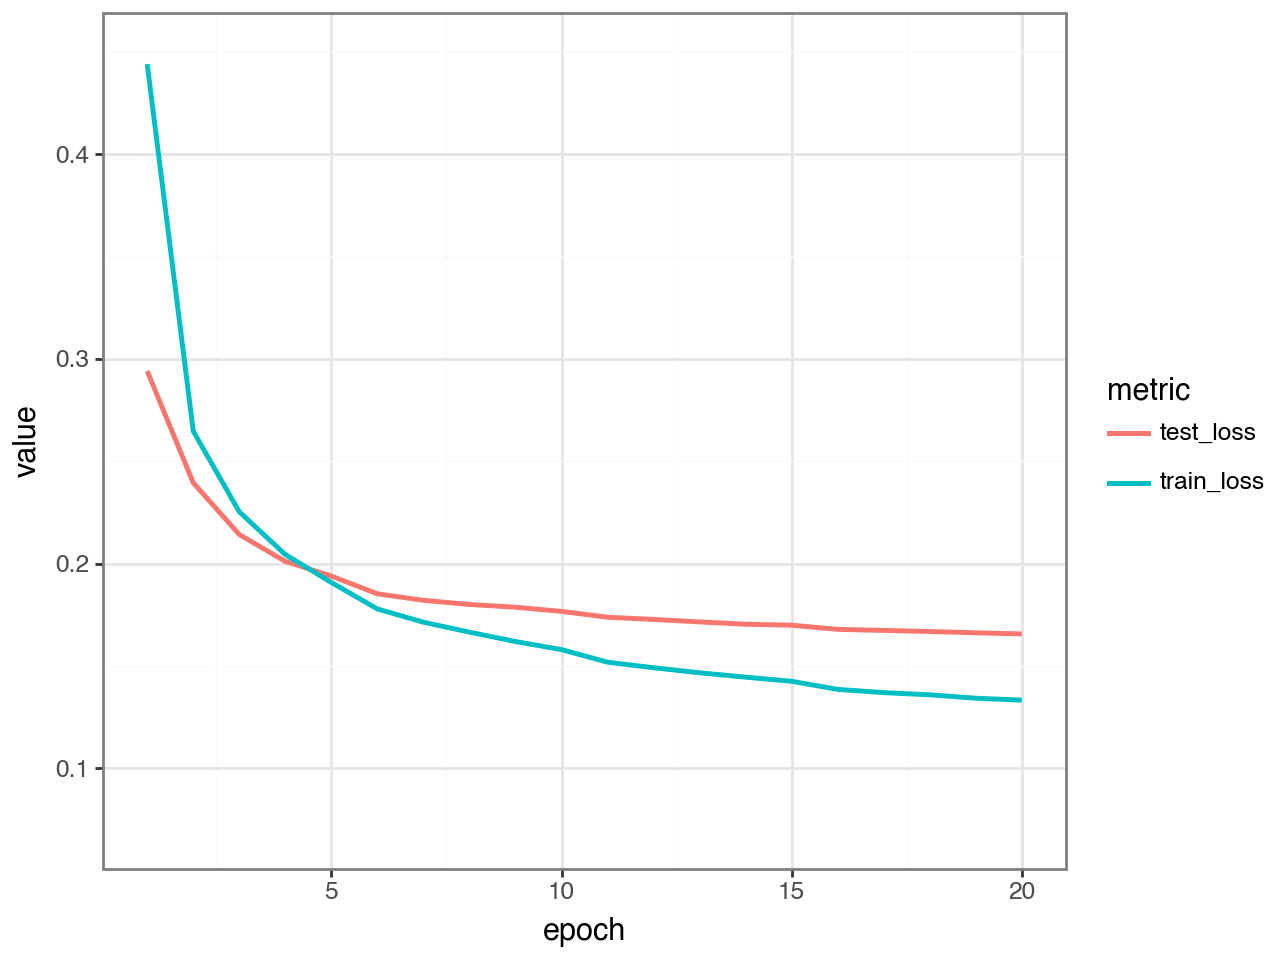

In [8]:
# wrangle the data
trainMetSummaries = trainMets.loc[:, ["epoch", "train_loss", "train_accuracy"]]\
                             .groupby("epoch")\
                             .aggregate("mean")\
                             .stack()\
                             .reset_index()
testMetSummaries = testMets.set_index("epoch")\
                           .stack()\
                           .reset_index()
metSummaries = pd.concat([trainMetSummaries, testMetSummaries], axis=0)
metSummaries.columns = ["epoch", "metric", "value"]
metLoss = metSummaries.loc[metSummaries.metric.isin(["train_loss", "test_loss"])]
metAcc = metSummaries.loc[metSummaries.metric.isin(["train_accuracy", "test_accuracy"])]

# plot the loss
ggoLoss = gg.ggplot(metLoss, gg.aes(x="epoch", y="value", color="metric"))
ggoLoss += gg.geom_line(size = 1)
ggoLoss += gg.ylim(0.07, 0.45)
ggoLoss

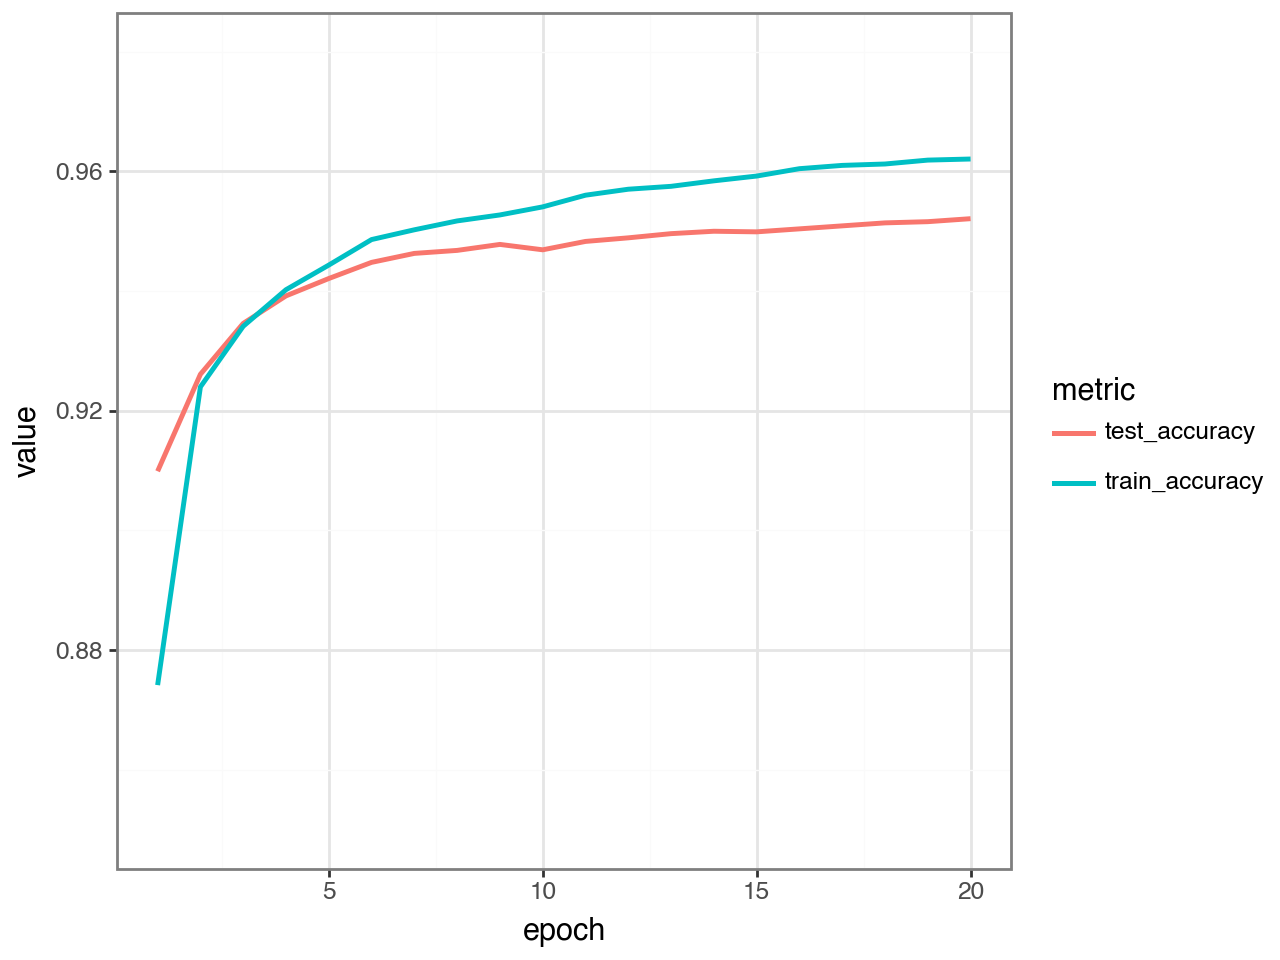

In [9]:
# plot the accuracy
ggoAcc = gg.ggplot(metAcc, gg.aes(x="epoch", y="value", color="metric"))
ggoAcc += gg.geom_line(size = 1)
ggoAcc += gg.ylim(0.85, 0.98)
ggoAcc

Finally, you may want to save the figures and the trained model.

In [10]:
if False: # change to `True` to save the figures and model
    # save the figures
    ggoLoss.save(filename = 'loss.png', height=4, width=6, units = 'in', dpi=600)
    ggoAcc.save(filename = 'acc.png', height=4, width=6, units = 'in', dpi=600)

    # save the trained model
    torch.save(model.state_dict(), "mnist_mlp.pt")

## Exercises

- Change the model by either modifying the number of hidden dimensions or by removing one hidden layer entirely and see how this affects model training.

- Change the training parameters (number of epochs, batch size, learning rate, gamma parameter) and see how this affects model training.
